In [1234]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB,ComplementNB,MultinomialNB,BernoulliNB,CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Loading the Data

In [1235]:
store_info = pd.read_csv("/kaggle/input/data-storm-4/Store-info.csv")
transactions=pd.read_csv("/kaggle/input/data-storm-4/Historical-transaction-data.csv")
testing = pd.read_csv("/kaggle/input/data-storm-4/Testing-data.csv")
# transactions["transaction_date"]
# len(transactions[transactions["shop_id"] =="SHOP008"]["item_description"].unique())
# transactions = transactions[~transactions["invoice_id"].isnull()]
JUICES = {name:index for index,name in enumerate(dict(transactions["item_description"].value_counts()).keys())}
print(JUICES)

def create_juice_vector(series):
    juice_series=series["item_description"].value_counts()
    ar = np.zeros(len(JUICES),int)
    for a,b in dict(juice_series).items():
#         print(a)
        ar[JUICES[a]]=b
    return ar

# create_juice_vector(transactions[transactions["shop_id"]=="SHOP008"])





{'GINGER BEER 1.5L': 0, 'CREAM SODA 1.5L': 1, 'CREAM SODA 500ML': 2, 'GINGER BEER 1L': 3, 'ORANGE BARLEY 1.5L': 4, 'NECTO 1.5L': 5, 'SODA 500ML': 6, 'BOTTLED DRINKING WATER 500ML': 7, 'SODA PET 1.5L': 8, 'FIT O ORANGE 1L': 9, 'LEMONADE 1.5L': 10, 'SODA 1L': 11, 'TONIC PET 500ML': 12, 'GINGER BEER 500ML': 13, 'CREAM SODA APPLE POP 1L': 14, 'FIT O ORANGE 200ML': 15, 'BOTTLED DRINKING WATER 1.5L': 16, 'ORANGE CRUSH 1.5L': 17, 'FIT O MIXED FRUIT 200ML': 18, 'FIT O MIXED FRUIT 1L': 19, 'FIT O MANGO 1L': 20, 'LEMONADE 500ML': 21, 'FIT O MANGO 200ML': 22, 'GINGER BEER SUGAR FREE 500ML': 23, 'DRY GINGER ALE PET 500ML': 24, 'STRAWBERRY MILK 180ML': 25, 'ORANGE CRUSH 500ML': 26, 'TWISTEE APPLE 1L': 27, 'NECTO 500ML': 28, 'CREAM SODA 1L': 29, 'GINGER BEER 400ML': 30, 'KIK COLA 1L': 31, 'LEMONADE 1L': 32, 'ORANGE CRUSH 1L': 33, 'NECTO 1L': 34, 'LIME CRUSH JUICE 1L': 35, 'CHOCOLATE MILK 180ML': 36}


In [1236]:
## covert data to integer
def stringToDate(dstr):
    dateStringList = dstr.split("T")
    dateExtracted = dateStringList[0]
    yearMonDay = dateExtracted.split("-")
    mon = int(yearMonDay[1])
    date = int(yearMonDay[2])
    if mon == 10:
        return date-15
    elif mon == 11:
        return date+16
    return date+46
transactions["date"] = transactions["transaction_date"].map(str).map(stringToDate)
transactions.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold,date
0,ORANGE BARLEY 1.5L,2021-12-11T00:00:00.000Z,147.0,BGXA,SHOP008,220,2,57
1,GINGER BEER 1.5L,2021-10-17T00:00:00.000Z,371.0,IA25,SHOP112,220,2,2
2,TONIC PET 500ML,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,160,2,59
3,CREAM SODA 1L,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,150,2,59
4,STRAWBERRY MILK 180ML,2021-10-23T00:00:00.000Z,1310.0,7S00,SHOP112,210,5,8


# Basic Feature Engineering and Seperating Training and Testing

In [1237]:
def compute_combined_data():
    transactions["income"] = transactions["item_price"]*transactions["quantity_sold"]
    transactions["weighted_income"] = transactions["income"]*(transactions["date"]/max(transactions["date"])+1)
    transactions["weighted_quantity"] = transactions["quantity_sold"]*(transactions["date"]/max(transactions["date"])+1)

    combined_data = store_info[['shop_id', 'shop_area_sq_ft']].copy()
    combined_data['income']= combined_data["shop_id"].map(
        lambda key:transactions[transactions["shop_id"]==key]["income"].sum()
    )
    combined_data["quantity"]=combined_data["shop_id"].map(
        lambda key:transactions[transactions["shop_id"]==key]["quantity_sold"].sum()
    )
    combined_data["product_diversity"]=combined_data["shop_id"].map(
        lambda key:len(transactions[transactions["shop_id"] ==key]["item_description"].unique())
    )
    combined_data["customer_diversity"]=combined_data["shop_id"].map(
        lambda key:len(transactions[transactions["shop_id"] ==key]["customer_id"].unique())
    )
    combined_data["income_growth"]=combined_data["shop_id"].map(
        lambda key:transactions[transactions["shop_id"] ==key]["weighted_income"].sum()
    )
    combined_data["income_growth"] = combined_data["income_growth"]/combined_data["income"]
    
    combined_data["quantity_growth"]=combined_data["shop_id"].map(
        lambda key:transactions[transactions["shop_id"] ==key]["weighted_quantity"].sum()
    )
    combined_data["quantity_growth"] = combined_data["quantity_growth"]/combined_data["quantity"]
    

    
    combined_data = combined_data.rename(columns = {"shop_area_sq_ft":"area"})
    combined_data["profile"] = store_info["shop_profile"].copy()
    combined_data["income_per_area"]=combined_data["income"]/combined_data["area"]
    combined_data["quantity_per_area"]=combined_data["quantity"]/combined_data["area"]
    combined_data["products_per_area"]=combined_data["product_diversity"]/combined_data["area"]
    combined_data["number_of_transactions"] = combined_data["shop_id"].map(
        lambda key:len(transactions[transactions["shop_id"] ==key])
    )/combined_data["area"]
    
    print(combined_data["number_of_transactions"].sum())
    return combined_data


In [1238]:
RECALCULATE_FEATURES = False
combined_data = None
if(RECALCULATE_FEATURES):
    combined_data = compute_combined_data()
    combined_data.to_csv("/kaggle/working/combined_data.csv")
else:
    combined_data = pd.read_csv("/kaggle/working/combined_data.csv")

combined_data["jv"]=combined_data["shop_id"].map(
    lambda key:create_juice_vector(transactions[transactions["shop_id"]==key])
)
    

791.8345572731404


In [1239]:
# Seprating Training and Testing
training_data = combined_data[~combined_data["profile"].isnull()].copy()
testing_data = combined_data[combined_data["profile"].isnull()].copy()


In [1240]:
#Remapping profiles to numbers
LOW = 0
MODERATE = 1
HIGH = 2
PREDICTION_CLASSES = [LOW,MODERATE,HIGH]
# Basic Feaure Names
ID = "shop_id"
PROFILE = "profile"
QUANTITY = "quantity"
INCOME = "income"
AREA = "area"
PRODUCT_DIVERSITY = "product_diversity"
CUSTOMER_DIVERSITY = "customer_diversity"
INCOME_PER_AREA = "income_per_area"
QUANTITY_PER_AREA = "quantity_per_area"
PRODUCTS_PER_AREA = "products_per_area"
NUMBER_OF_TRANSACTIONS = "number_of_transactions"
INCOME_GROWTH = "income_growth"
QUANTITY_GROWTH = "quantity_growth"
JV = "jv"
IP_TO_SP = {
    LOW:"Low",
    MODERATE:"Moderate",
    HIGH:"High"
}

SP_TO_IP = {value:key for key,value in IP_TO_SP.items()}
def iprofile_to_sprofile(iprofile:int):
    return IP_TO_SP[iprofile]
def sprofile_to_iprofile(sprofile:str):
    return SP_TO_IP[sprofile]


FEATURE_OPTION_1 =(AREA,PRODUCT_DIVERSITY,CUSTOMER_DIVERSITY,INCOME_PER_AREA)
FEATURE_OPTION_2 = (AREA,PRODUCT_DIVERSITY,CUSTOMER_DIVERSITY,INCOME_PER_AREA,INCOME_GROWTH,QUANTITY_GROWTH)
FEATURES_USED = FEATURE_OPTION_1
training_data['profile'] = training_data['profile'].map(sprofile_to_iprofile)
# training_data.head()

# Visual Analysis of Data

In [1241]:
low_data = training_data[training_data[PROFILE]==LOW]
moderate_data = training_data[training_data[PROFILE]==MODERATE]
high_data = training_data[training_data[PROFILE]==HIGH]

<AxesSubplot:>

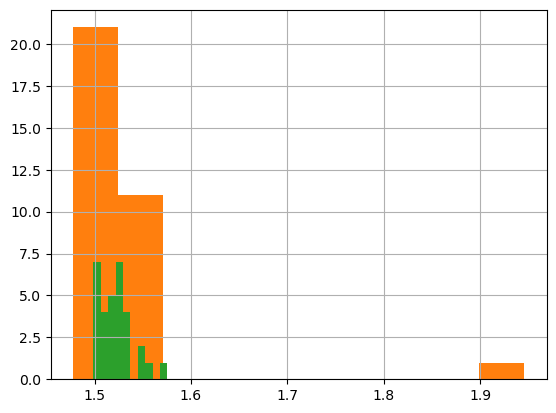

In [1242]:
#area
feature = QUANTITY_GROWTH
low_data[feature].hist()
# plt.show()
moderate_data[feature].hist()
# plt.show()
high_data[feature].hist()
# plt.show()

## Feature Vector Creation

In [1243]:
def create_feature_vectors(df,features,prediction_name=None,normalization_parameters=None,normalize=True):
    #returns feature vector array and predictions if prediction_name is given
    df = df.copy() #creating a local copy
    #calculating normalization paramteres if they are not provided
    
    if(normalization_parameters is None):
        print("************************************")
        print("Caclulating normalizing paramters!!!")
        print("************************************")
        normalization_parameters = {feature:(df[feature].mean(),df[feature].std()) for feature in features}
    
    #normalizing according to the paramters
    if(normalize):
        for feature in features:
            mean,std = normalization_parameters[feature]
            df[feature] = (df[feature] - mean)/std
        
    feature_vectors = np.stack([df[feature].to_numpy() for feature in features],axis=1)
#     feature_vectors = np.stack(df['jv'],axis=0)
    if(prediction_name is None):
        return feature_vectors,normalization_parameters,None
    
    return feature_vectors,normalization_parameters,df[prediction_name].to_numpy()   

def get_jv_feature_vectors(df):
 
    jv_feature_vectors = np.stack(df['jv'],axis=0)
    return jv_feature_vectors
get_jv_feature_vectors(training_data).shape
#     return feature_vectors,normalization_parameters,df[prediction_name].to_numpy()  

(100, 37)

In [1244]:
data = training_data
# data= training_data.head()
feature_vectors,normalization_parameters,ground_truth = create_feature_vectors(df=data,features=FEATURES_USED,prediction_name=PROFILE,normalize=True)
feature_vectors.shape

************************************
Caclulating normalizing paramters!!!
************************************


(100, 4)

# Functions for evaluvations

In [1245]:
def create_confusion_matrix(ground_truth,predictions,features):
    n_features = len(features)
    confusion_matrix = np.zeros((n_features,n_features))
    for index1,f1 in enumerate(features):
        for index2,f2 in enumerate(features):
            confusion_matrix[index1,index2] = np.sum((ground_truth == f1) & (predictions == f2))
    assert(len(predictions) == len(ground_truth) and len(predictions) == np.sum(confusion_matrix))
    return confusion_matrix/np.sum(confusion_matrix)
    

# Trying Out Basic Classification Methods

In [1246]:
from sklearn.model_selection import train_test_split
def evaluvate_algorithm_train_test(classifire,training_features,ground_truth,test_percentage=0.3):
    feature_train,feature_test,gt_train,gt_test = train_test_split(training_features,
                                                                    ground_truth,
                                                                    test_size=test_percentage)
    classifire.fit(feature_train,gt_train)
    pd_train = classifire.predict(feature_train)
    print(f"***************training data*****************")
    confusion_matrix = create_confusion_matrix(gt_train,pd_train,[0,1,2])
    score = f1_score(y_true=gt_train,y_pred=pd_train,labels=PREDICTION_CLASSES,average='macro')
    print(confusion_matrix)
    print(score)
    print(f"*********************************************")
    
    pd_test = classifire.predict(feature_test)
    print(f"***************testing data*****************")
    confusion_matrix = create_confusion_matrix(gt_test,pd_test,[0,1,2])
    score = f1_score(y_true=gt_test,y_pred=pd_test,labels=PREDICTION_CLASSES,average='macro')
    print(confusion_matrix)
    print(score)
    print(f"*********************************************")
    return confusion_matrix,score,classifire
    
def evaluvate_algorithm_total(classifire,feature_train,gt_train):
    classifire.fit(feature_train,gt_train)
    pd_train = classifire.predict(feature_train)
    print(f"***************Total data*****************")
    confusion_matrix = create_confusion_matrix(gt_train,pd_train,[0,1,2])
    score = f1_score(y_true=gt_train,y_pred=pd_train,labels=PREDICTION_CLASSES,average='macro')
    print(confusion_matrix)
    print(score)
    print(f"*********************************************")
    return confusion_matrix,score,classifire

    
    

# Support Vector Machines

In [1247]:
def try_out_svm(kernel):
    classifire = svm.SVC(kernel=kernel)
    evaluvate_algorithm_train_test(classifire,feature_vectors,ground_truth)
    
    return evaluvate_algorithm_total(classifire,feature_vectors,ground_truth)

In [1248]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
best_svm = None
best_score = -1
for kernel in kernels:
    print(f"************Trying out kernel = {kernel}******************")
    cm,score,cla = try_out_svm(kernel)
    if(best_score < score):
        best_svm = cla
        best_score = score
    print(cm)
    print(f"f1 score:{score}")
    print(f"**********************************************************")

************Trying out kernel = linear******************
***************training data*****************
[[0.3        0.05714286 0.04285714]
 [0.11428571 0.18571429 0.04285714]
 [0.05714286 0.01428571 0.18571429]]
0.670091637304752
*********************************************
***************testing data*****************
[[0.16666667 0.06666667 0.03333333]
 [0.1        0.16666667 0.03333333]
 [0.         0.2        0.23333333]]
0.5719696969696969
*********************************************
***************Total data*****************
[[0.22 0.08 0.06]
 [0.05 0.23 0.05]
 [0.04 0.02 0.25]]
0.6999849238655208
*********************************************
[[0.22 0.08 0.06]
 [0.05 0.23 0.05]
 [0.04 0.02 0.25]]
f1 score:0.6999849238655208
**********************************************************
************Trying out kernel = poly******************
***************training data*****************
[[0.32857143 0.         0.01428571]
 [0.21428571 0.12857143 0.        ]
 [0.17142857 0.         0.1

# Naive Bayes

In [1249]:
algos = {
    "Gaussian":GaussianNB,
#     "Multinomial":MultinomialNB,
#     "Complement":ComplementNB,
    "Bernouli":BernoulliNB,
#     "Categorial":CategoricalNB
}
best_naive = None
best_score = -1
for name,algo in algos.items():
    print(f"***************************{name}*******************************")
    classifire_gnb = algo()
    evaluvate_algorithm_train_test(classifire_gnb,feature_vectors,ground_truth)
    cm,score,cla = evaluvate_algorithm_total(classifire_gnb,feature_vectors,ground_truth)
    if(score > best_score):
        best_naive = cla
        best_score = score
    print("****************************************************************")

***************************Gaussian*******************************
***************training data*****************
[[0.32857143 0.02857143 0.02857143]
 [0.12857143 0.12857143 0.02857143]
 [0.07142857 0.01428571 0.24285714]]
0.6846590909090908
*********************************************
***************testing data*****************
[[0.16666667 0.1        0.03333333]
 [0.16666667 0.13333333 0.13333333]
 [0.03333333 0.         0.23333333]]
0.5333333333333333
*********************************************
***************Total data*****************
[[0.28 0.04 0.04]
 [0.13 0.14 0.06]
 [0.06 0.01 0.24]]
0.6505406240346
*********************************************
****************************************************************
***************************Bernouli*******************************
***************training data*****************
[[0.28571429 0.01428571 0.08571429]
 [0.17142857 0.04285714 0.08571429]
 [0.07142857 0.         0.24285714]]
0.5105555555555555
****************************

# KNN

In [1250]:
classifire_knn = KNeighborsClassifier(n_neighbors=3)
evaluvate_algorithm_train_test(classifire_knn,feature_vectors,ground_truth)
cm,score,classifire_knn = evaluvate_algorithm_total(classifire_knn,feature_vectors,ground_truth)

***************training data*****************
[[0.38571429 0.01428571 0.01428571]
 [0.08571429 0.22857143 0.        ]
 [0.01428571 0.05714286 0.2       ]]
0.8082861051397302
*********************************************
***************testing data*****************
[[0.13333333 0.1        0.        ]
 [0.2        0.16666667 0.        ]
 [0.13333333 0.06666667 0.2       ]]
0.5079365079365079
*********************************************
***************Total data*****************
[[0.32 0.03 0.01]
 [0.06 0.27 0.  ]
 [0.05 0.03 0.23]]
0.8215573456079786
*********************************************


# Ada Boost

In [1251]:
from sklearn.ensemble import AdaBoostClassifier
classifire_adb = AdaBoostClassifier()
evaluvate_algorithm_train_test(classifire_adb,feature_vectors,ground_truth)
cm,score,classifire_adb = evaluvate_algorithm_total(classifire_adb,feature_vectors,ground_truth)

***************training data*****************
[[0.28571429 0.05714286 0.02857143]
 [0.05714286 0.28571429 0.01428571]
 [0.02857143 0.04285714 0.2       ]]
0.772079772079772
*********************************************
***************testing data*****************
[[0.26666667 0.03333333 0.03333333]
 [0.03333333 0.13333333 0.1       ]
 [0.03333333 0.1        0.26666667]]
0.6555555555555556
*********************************************
***************Total data*****************
[[0.28 0.06 0.02]
 [0.05 0.27 0.01]
 [0.04 0.04 0.23]]
0.7818564676531512
*********************************************


# Gaussian Process

In [1252]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
classifire_gau = GaussianProcessClassifier(1.0 * RBF(1.0))

evaluvate_algorithm_train_test(classifire_gau,feature_vectors,ground_truth)
cm,score,classifire_gau = evaluvate_algorithm_total(classifire_gau,feature_vectors,ground_truth)

***************training data*****************
[[0.25714286 0.08571429 0.02857143]
 [0.02857143 0.25714286 0.04285714]
 [0.04285714 0.02857143 0.22857143]]
0.7437641723356009
*********************************************
***************testing data*****************
[[0.26666667 0.06666667 0.        ]
 [0.16666667 0.06666667 0.1       ]
 [0.1        0.         0.23333333]]
0.5336996336996337
*********************************************
***************Total data*****************
[[0.28 0.06 0.02]
 [0.06 0.23 0.04]
 [0.06 0.03 0.22]]
0.730099041606624
*********************************************


# sklearn neuralnet

In [1253]:
from sklearn.neural_network import MLPClassifier
classifire_nn = MLPClassifier(hidden_layer_sizes=(100,100),alpha=1e-2, max_iter=100000)
evaluvate_algorithm_train_test(classifire_nn,feature_vectors,ground_truth)
cm,score,classifire_nn = evaluvate_algorithm_total(classifire_nn,feature_vectors,ground_truth)

***************training data*****************
[[0.28571429 0.         0.        ]
 [0.         0.37142857 0.        ]
 [0.         0.         0.34285714]]
1.0
*********************************************
***************testing data*****************
[[0.26666667 0.16666667 0.1       ]
 [0.13333333 0.06666667 0.03333333]
 [0.06666667 0.         0.16666667]]
0.4813492063492064
*********************************************
***************Total data*****************
[[0.36 0.   0.  ]
 [0.   0.33 0.  ]
 [0.   0.   0.31]]
1.0
*********************************************


# Decision Tree

In [1254]:
classifire_tree = DecisionTreeClassifier()
classifire_tree.fit(feature_vectors,ground_truth)

evaluvate_algorithm_train_test(classifire_tree,feature_vectors,ground_truth)
cm,score,classifire_tree = evaluvate_algorithm_total(classifire_tree,feature_vectors,ground_truth)

***************training data*****************
[[0.37142857 0.         0.        ]
 [0.         0.32857143 0.        ]
 [0.         0.         0.3       ]]
1.0
*********************************************
***************testing data*****************
[[0.23333333 0.06666667 0.03333333]
 [0.2        0.13333333 0.        ]
 [0.13333333 0.03333333 0.16666667]]
0.5380355846042121
*********************************************
***************Total data*****************
[[0.36 0.   0.  ]
 [0.   0.33 0.  ]
 [0.   0.   0.31]]
1.0
*********************************************


In [1255]:
classifire_forest = RandomForestClassifier()
classifire_forest.fit(feature_vectors,ground_truth)

evaluvate_algorithm_train_test(classifire_forest,feature_vectors,ground_truth)
cm,score,classifire_forest = evaluvate_algorithm_total(classifire_forest,feature_vectors,ground_truth)

***************training data*****************
[[0.35714286 0.         0.        ]
 [0.         0.3        0.        ]
 [0.         0.         0.34285714]]
1.0
*********************************************
***************testing data*****************
[[0.23333333 0.03333333 0.1       ]
 [0.1        0.13333333 0.16666667]
 [0.03333333 0.         0.2       ]]
0.5594601476954418
*********************************************
***************Total data*****************
[[0.36 0.   0.  ]
 [0.   0.33 0.  ]
 [0.   0.   0.31]]
1.0
*********************************************


# Evaluvating the test data set

In [1256]:
testing_data.head()

,shop_id,area,income,quantity,product_diversity,customer_diversity,income_growth,quantity_growth,profile,income_per_area,quantity_per_area,products_per_area,number_of_transactions,jv
100,SHOP046,545,2607865,6941,36,1736,1.592754,1.522816,NaN,4785.073394,12.735780,0.066055,6.308257,"[403, 332, 228, 144, 136, 232, 122, 223, 127, ..."
101,SHOP024,676,1308795,5274,36,1641,1.527837,1.506195,NaN,1936.087278,7.801775,0.053254,4.264793,"[332, 277, 248, 128, 118, 189, 63, 133, 85, 79..."
102,SHOP023,617,2570425,7946,37,2227,1.486956,1.509670,NaN,4166.004862,12.878444,0.059968,6.649919,"[501, 514, 364, 176, 234, 189, 120, 41, 191, 9..."
103,SHOP097,310,2642380,6934,32,1669,1.504433,1.519869,NaN,8523.806452,22.367742,0.103226,10.154839,"[388, 162, 172, 0, 114, 124, 191, 101, 131, 16..."
104,SHOP044,715,1310440,4965,36,1552,1.553752,1.521728,NaN,1832.783217,6.944056,0.050350,3.693706,"[306, 189, 168, 136, 119, 77, 214, 13, 177, 60..."


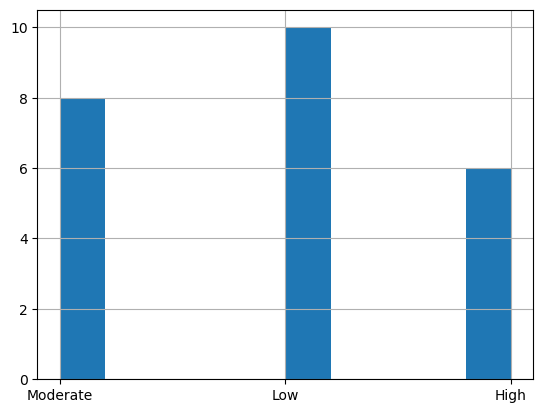

In [1257]:
data = testing_data.copy()
# data= training_data.head()
test_feature_vectors,normalization_parameters,_ = create_feature_vectors(df=data,features=FEATURES_USED,prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
profile_predictions =classifire_nn.predict(test_feature_vectors)
copy_testing = testing.copy()
copy_testing['shop_profile'] = list(map(iprofile_to_sprofile,profile_predictions,))
copy_testing['shop_profile'].hist()
data['profile']=copy_testing['shop_profile'].rename(index=lambda x : x+100)

# copy_testing
# data

In [1258]:
copy_testing.to_csv("/kaggle/working/per_area_feautures_forest_2_predictions.csv",index=False)

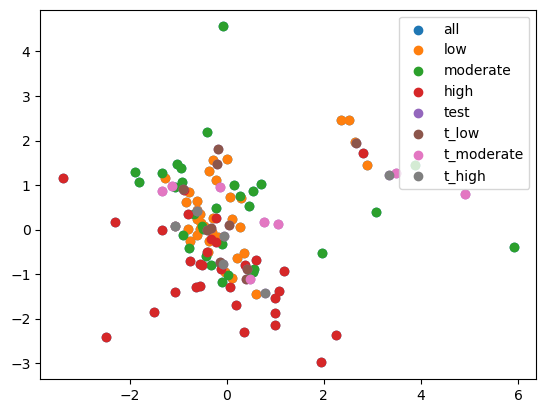

In [1259]:
from sklearn.decomposition import PCA
redu = PCA(n_components=2)
redu.fit(feature_vectors)
dmrf = redu.transform(feature_vectors)
lfv,_,_ = create_feature_vectors(df=low_data,features=FEATURES_USED,prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
mfv,_,_ = create_feature_vectors(df=moderate_data,features=FEATURES_USED,prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
hfv,_,_ = create_feature_vectors(df=high_data,features=FEATURES_USED,prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
rlfv = redu.transform(lfv)
rmfv = redu.transform(mfv)
rhfv = redu.transform(hfv)
rtfv = redu.transform(test_feature_vectors)
tlfv,_,_ = create_feature_vectors(df=data[data['profile']=="Low"],features=FEATURES_USED,prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
tmfv,_,_ = create_feature_vectors(df=data[data['profile']=="Moderate"],features=FEATURES_USED,prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
thfv,_,_ = create_feature_vectors(df=data[data['profile']=="High"],features=FEATURES_USED,prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
trlfv = redu.transform(tlfv)
trmfv = redu.transform(tmfv)
trhfv = redu.transform(thfv)
plt.scatter(dmrf[:,0],dmrf[:,1],label="all")
plt.scatter(rlfv[:,0],rlfv[:,1],label="low")
plt.scatter(rmfv[:,0],rmfv[:,1],label="moderate")
plt.scatter(rhfv[:,0],rhfv[:,1],label="high")
plt.scatter(rtfv[:,0],rtfv[:,1],label="test")
plt.scatter(trlfv[:,0],trlfv[:,1],label="t_low")
plt.scatter(trmfv[:,0],trmfv[:,1],label="t_moderate")
plt.scatter(trhfv[:,0],trhfv[:,1],label="t_high")
plt.legend()
# plt.xlim(-6,  6)
# plt.ylim(-6, 6)
plt.show()
plt.show()

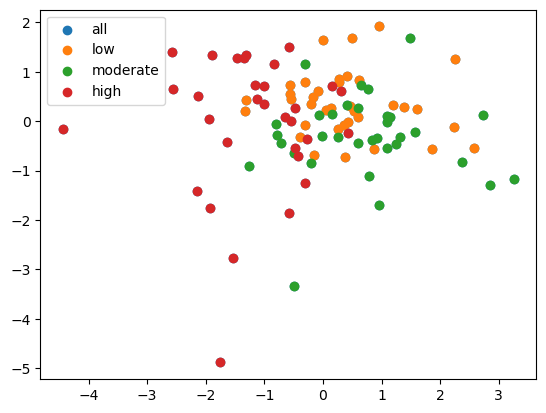

In [1260]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
redu = LinearDiscriminantAnalysis()
redu.fit(feature_vectors,ground_truth)
dmrf = redu.transform(feature_vectors)
lfv,_,_ = create_feature_vectors(df=low_data,features=FEATURES_USED,prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
mfv,_,_ = create_feature_vectors(df=moderate_data,features=FEATURES_USED,prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
hfv,_,_ = create_feature_vectors(df=high_data,features=FEATURES_USED,prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
rlfv = redu.transform(lfv)
rmfv = redu.transform(mfv)
rhfv = redu.transform(hfv)
rtfv = redu.transform(test_feature_vectors)
tlfv,_,_ = create_feature_vectors(df=data[data['profile']=="Low"],features=FEATURES_USED,prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
tmfv,_,_ = create_feature_vectors(df=data[data['profile']=="Moderate"],features=FEATURES_USED,prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
thfv,_,_ = create_feature_vectors(df=data[data['profile']=="High"],features=FEATURES_USED,prediction_name=None,normalize=True,normalization_parameters=normalization_parameters)
trlfv = redu.transform(tlfv)
trmfv = redu.transform(tmfv)
trhfv = redu.transform(thfv)
plt.scatter(dmrf[:,0],dmrf[:,1],label="all")
plt.scatter(rlfv[:,0],rlfv[:,1],label="low")
plt.scatter(rmfv[:,0],rmfv[:,1],label="moderate")
plt.scatter(rhfv[:,0],rhfv[:,1],label="high")
# plt.scatter(rtfv[:,0],rtfv[:,1],label="test")
# plt.scatter(trlfv[:,0],trlfv[:,1],label="t_low")
# plt.scatter(trmfv[:,0],trmfv[:,1],label="t_moderate")
# plt.scatter(trhfv[:,0],trhfv[:,1],label="t_high")
plt.legend()
# plt.xlim(-6,  6)
# plt.ylim(-6, 6)
plt.show()
plt.show()

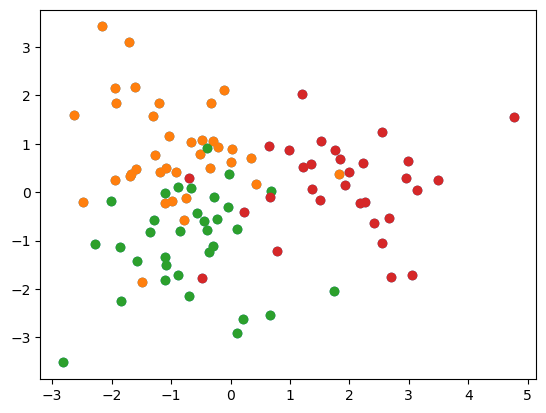

In [1270]:
lda = LinearDiscriminantAnalysis()
jvf = get_jv_feature_vectors(training_data)
lda.fit(jvf,ground_truth)
rjvf = lda.transform(jvf)
plt.scatter(rjvf[:,0],rjvf[:,1])
for dd in (low_data,moderate_data,high_data):
    ljvf = get_jv_feature_vectors(dd)
    rljvf = lda.transform(ljvf)
    plt.scatter(rljvf[:,0],rljvf[:,1])


In [1262]:
ss_linear = svm.SVC(kernel="linear")
evaluvate_algorithm_total(ss_linear,rjvf,ground_truth)
_,_,ss_linear = evaluvate_algorithm_train_test(ss_linear,rjvf,ground_truth)

***************Total data*****************
[[0.29 0.05 0.02]
 [0.06 0.25 0.02]
 [0.01 0.03 0.27]]
0.8113663516889323
*********************************************
***************training data*****************
[[0.25714286 0.02857143 0.02857143]
 [0.05714286 0.25714286 0.02857143]
 [0.02857143 0.04285714 0.27142857]]
0.7856922602528523
*********************************************
***************testing data*****************
[[0.36666667 0.1        0.        ]
 [0.06666667 0.23333333 0.        ]
 [0.03333333 0.         0.2       ]]
0.8152111046847889
*********************************************


In [1263]:
ss_linear = svm.SVC()
evaluvate_algorithm_total(ss_linear,rjvf,ground_truth)
_,_,ss_linear = evaluvate_algorithm_train_test(ss_linear,rjvf,ground_truth)

***************Total data*****************
[[0.3  0.05 0.01]
 [0.06 0.26 0.01]
 [0.01 0.03 0.27]]
0.8326790704014176
*********************************************
***************training data*****************
[[0.24285714 0.07142857 0.        ]
 [0.02857143 0.3        0.01428571]
 [0.01428571 0.04285714 0.28571429]]
0.8302885095337925
*********************************************
***************testing data*****************
[[0.36666667 0.03333333 0.06666667]
 [0.03333333 0.23333333 0.03333333]
 [0.         0.         0.23333333]]
0.8310708898944194
*********************************************


In [1264]:
nn = MLPClassifier(hidden_layer_sizes=(100,100),alpha=1, max_iter=1000)
evaluvate_algorithm_total(nn,rjvf,ground_truth)
_,_,nn = evaluvate_algorithm_train_test(nn,rjvf,ground_truth)

***************Total data*****************
[[0.29 0.05 0.02]
 [0.06 0.26 0.01]
 [0.01 0.03 0.27]]
0.8223069533933248
*********************************************
***************training data*****************
[[0.3        0.05714286 0.01428571]
 [0.05714286 0.27142857 0.        ]
 [0.01428571 0.02857143 0.25714286]]
0.8331196581196582
*********************************************
***************testing data*****************
[[0.23333333 0.03333333 0.06666667]
 [0.03333333 0.26666667 0.03333333]
 [0.         0.03333333 0.3       ]]
0.7986531986531987
*********************************************


In [1265]:
forest = RandomForestClassifier()
evaluvate_algorithm_total(forest,rjvf,ground_truth)
_,_,forest = evaluvate_algorithm_train_test(forest,rjvf,ground_truth)

***************Total data*****************
[[0.36 0.   0.  ]
 [0.   0.33 0.  ]
 [0.   0.   0.31]]
1.0
*********************************************
***************training data*****************
[[0.38571429 0.         0.        ]
 [0.         0.25714286 0.        ]
 [0.         0.         0.35714286]]
1.0
*********************************************
***************testing data*****************
[[0.2        0.1        0.        ]
 [0.06666667 0.4        0.03333333]
 [0.         0.         0.2       ]]
0.8096530920060333
*********************************************


In [1266]:
knn = KNeighborsClassifier(n_neighbors=3)
evaluvate_algorithm_train_test(knn,rjvf,ground_truth)
cm,score,knn = evaluvate_algorithm_total(knn,rjvf,ground_truth)

***************training data*****************
[[0.28571429 0.02857143 0.01428571]
 [0.04285714 0.28571429 0.01428571]
 [0.01428571 0.02857143 0.28571429]]
0.8577620173364854
*********************************************
***************testing data*****************
[[0.36666667 0.06666667 0.        ]
 [0.         0.3        0.        ]
 [0.         0.         0.26666667]]
0.9388888888888888
*********************************************
***************Total data*****************
[[0.33 0.02 0.01]
 [0.05 0.28 0.  ]
 [0.02 0.02 0.27]]
0.8817379171527252
*********************************************


In [1267]:
def predict(testing_data,algo,testing):
    data = testing_data.copy()
    # data= training_data.head()
    test_feature_vectors = lda.transform(get_jv_feature_vectors(df=data))
    profile_predictions =algo.predict(test_feature_vectors)
    copy_testing = testing.copy()
    copy_testing['shop_profile'] = list(map(iprofile_to_sprofile,profile_predictions,))
#     print(list(data['shop_id']),list(copy_testing['shop_id']))
    assert(list(data['shop_id']) == list(copy_testing['shop_id']))
#     data['profile']=copy_testing['shop_profile'].rename(index=lambda x : x+100)

    return copy_testing.copy()

ss_predictions = predict(testing_data,ss,testing)
ss_linear_predictions = predict(testing_data,ss_linear,testing)
nn_predictions = predict(testing_data,nn,testing)
knn_predictions = predict(testing_data,knn,testing)
forest_predictions = predict(testing_data,forest,testing)
# best_svm_predictions = predict(testing_data,best_svm,testing)


evaluvation_table = testing.copy().drop("shop_profile",axis=1)

evaluvation_table["svm"]=ss_predictions["shop_profile"]
evaluvation_table["nnl"]=nn_predictions["shop_profile"]
evaluvation_table["knn"]=knn_predictions["shop_profile"]
# evaluvation_table["forest"]=forest_predictions["shop_profile"]
evaluvation_table["ss_linear"]=ss_linear_predictions["shop_profile"]
# evaluvation_table["best_svm"]=best_svm_predictions["shop_profile"]

evaluvation_table

,shop_id,svm,nnl,knn,ss_linear
0,SHOP046,Low,Low,High,Low
1,SHOP024,Low,Low,Low,Moderate
2,SHOP023,Moderate,Moderate,Moderate,Moderate
3,SHOP097,Moderate,Moderate,Moderate,Moderate
4,SHOP044,Low,Low,Moderate,Moderate
5,SHOP030,Low,Low,Low,Low
6,SHOP038,High,High,Low,High
7,SHOP029,Low,Low,Low,Low
8,SHOP096,Low,Low,Low,Low
9,SHOP092,High,High,Low,High


In [1268]:
ss_predictions.to_csv("/kaggle/working/svm_predictions_juice.csv",index=False)
nn_predictions.to_csv("/kaggle/working/nn_predictions_juice.csv",index=False)